<a href="https://colab.research.google.com/github/apschlissel/ucb_mids_w205/blob/main/Allison_Schlissel_project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [ ]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [ ]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [ ]:
def Q1(num_examples=5):
    ### STUDENT START ###
    #loop through to get each text and label
    for example in range(num_examples):
      #get train examples
      print('Train example:')
      print(train_data[example])
      print(' ')
      #get train labels
      print('Train label:')
      #map train example number to list so we can get text instead of number
      tl = train_labels[example]
      print(newsgroups_train.target_names[tl])
      print(' ')
    ### STUDENT END ###

Q1(5)

Train example:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
 
Train label:
comp.graphics
 
Train example:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.


### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [ ]:
def Q2():
    ### STUDENT START ###

    #part 1
    def word_unigrams(train_data):
      print('Question 1: ')
      vectorizer = CountVectorizer()
      uni_vect = vectorizer.fit_transform(train_data)
      #vocabulary size
      print('Vocabulary size:', uni_vect.nnz)
      #average number of non-zeros per example
      nonzero_rows = np.count_nonzero(uni_vect.toarray(), axis=1)
      print('Avg number of non-zeros per example:', np.mean(nonzero_rows))
      #fraction of non-zero to total
      sparse_shape = uni_vect.get_shape()[0]*uni_vect.get_shape()[1]
      print('Fraction of non-zero elements in matrix:', str(uni_vect.nnz)+'/'+str(sparse_shape))
      #alphabetical feature strings
      vect_names = vectorizer.get_feature_names()
      print('First and last feature strings: ', vect_names[0], vect_names[-1])
      print('')
    
    def restricted_vocab(train_data):
      print('Question 2:')
      #vectorize text with vocab
      vectorizer = CountVectorizer(vocabulary=["atheism", "graphics", "space", "religion"])
      uni_vect_restricted = vectorizer.fit_transform(train_data)
      #average number of non-zeros per example
      nonzero_rows = np.count_nonzero(uni_vect_restricted.toarray(), axis=1)
      print('Avg number of non-zeros per example:', np.mean(nonzero_rows))
      print('')
    
    def bigrams_trigrams_char(train_data):
      print('Question 3:')
      #vectorize text, add character & ngram range
      vectorizer = CountVectorizer(analyzer='char', ngram_range=(2,3))
      vect_bgc = vectorizer.fit_transform(train_data)
      #vocabulary size
      print('Vocabulary size, character bigrams/trigrams:', vect_bgc.nnz)
      print('')
    
    def frequent_words(train_data):
      print('Question 4:')
      #vectorize text, prune words w/ less than 10 occurences
      vectorizer = CountVectorizer(min_df=10)
      uni_vect_min10 = vectorizer.fit_transform(train_data)
      print('Size of vocabulary, unigrams greater than 10 occurrences:', uni_vect_min10.nnz)
      print('')

    def dev_vs_train(train_data, dev_data):
      print('Question 5:')
      vectorizer = CountVectorizer()
      vect_train = vectorizer.fit_transform(train_data)
      vect_train_names = vectorizer.get_feature_names()
      vect_dev = vectorizer.fit_transform(dev_data)
      vect_dev_names = vectorizer.get_feature_names()
      new_dev = [name for name in vect_dev_names if name not in vect_train_names]
      print('Fraction: ' +  str(len(new_dev)) + '/' + str(len(vect_dev_names)))
      print('')


    ### STUDENT END ###
    word_unigrams(train_data)
    restricted_vocab(train_data)
    bigrams_trigrams_char(train_data)
    frequent_words(train_data)
    dev_vs_train(train_data, dev_data)
Q2()

Question 1: 
Vocabulary size: 196700
Avg number of non-zeros per example: 96.70599803343165
Fraction of non-zero elements in matrix: 196700/54671886
First and last feature strings:  00 zyxel

Question 2:
Avg number of non-zeros per example: 0.26843657817109146

Question 3:
Vocabulary size, character bigrams/trigrams: 1391646

Question 4:
Size of vocabulary, unigrams greater than 10 occurrences: 147823

Question 5:
Fraction: 4027/16246



### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [ ]:
def Q3():
    ### STUDENT START ###

    def knn(train_data, train_labels, dev_data, dev_labels):
      
      #vectorize & transform text
      vectorizer = CountVectorizer()
      vtrain = vectorizer.fit_transform(train_data)
      vdev = vectorizer.transform(dev_data)

      print('KNN Results:')

      #knn models
      for k in range(1,8,2):
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(vtrain, train_labels)
        preds = clf.predict(vdev)
        print('F1, N='+str(k)+':', metrics.f1_score(dev_labels, preds, average="weighted"))
      print('')

    def naive_bayes(train_data, train_labels, dev_data, dev_labels):

      #vectorize & transform text
      vectorizer = CountVectorizer()
      vtrain = vectorizer.fit_transform(train_data)
      vdev = vectorizer.transform(dev_data)

      print('Naive Bayes Results:')

      #naive bayes models
      alphas = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
      for a in alphas:
        clf = MultinomialNB(alpha=a)
        clf.fit(vtrain, train_labels)
        preds = clf.predict(vdev)
        print('F1, alpha='+str(a)+':', metrics.f1_score(dev_labels, preds, average="weighted"))
      print('')
    
    def logistic_regression(train_data, train_labels, dev_data, dev_labels):

      #vectorize & transform text
      vectorizer = CountVectorizer()
      vtrain = vectorizer.fit_transform(train_data)
      vdev = vectorizer.transform(dev_data)

      print('Logistic Regression Results:')

      c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
      for c in c_values:
        clf = LogisticRegression(C=c, solver="liblinear", multi_class="auto")
        clf.fit(vtrain, train_labels)
        preds = clf.predict(vdev)
        print('F1, c='+str(c)+':', metrics.f1_score(dev_labels, preds, average="weighted"))
        #print('Weights: ', sum(clf.coef_))
        importance = clf.coef_
        for i, v in enumerate(importance):
          print('Class', i, 'score:', sum([x**2 for x in v]))
        print('')


    knn(train_data, train_labels, dev_data, dev_labels)
    naive_bayes(train_data, train_labels, dev_data, dev_labels)
    logistic_regression(train_data, train_labels, dev_data, dev_labels)
    ### STUDENT END ###
Q3()

KNN Results:
F1, N=1: 0.3805030018531525
F1, N=3: 0.4084150225437623
F1, N=5: 0.4287607236218357
F1, N=7: 0.45047910006117586

Naive Bayes Results:
F1, alpha=1e-10: 0.747240657284563
F1, alpha=0.0001: 0.7628348704826354
F1, alpha=0.001: 0.7702518836155706
F1, alpha=0.01: 0.7751663218544357
F1, alpha=0.1: 0.7903052385098862
F1, alpha=0.5: 0.7862862961995258
F1, alpha=1.0: 0.7777320236017224
F1, alpha=2.0: 0.7689966472342658
F1, alpha=10.0: 0.6674814338256576

Logistic Regression Results:
F1, c=0.001: 0.6193046812006844
Feature 0 score: 0.16509345166731987
Feature 1 score: 0.20095274690581916
Feature 2 score: 0.180670937543784
Feature 3 score: 0.18724278437848627

F1, c=0.01: 0.6646997417582748
Feature 0 score: 2.541530980704418
Feature 1 score: 2.939709368357306
Feature 2 score: 2.862469124420476
Feature 3 score: 2.2500292743089343

F1, c=0.1: 0.6966243542418833
Feature 0 score: 27.132067887249317
Feature 1 score: 24.663104303462315
Feature 2 score: 27.458463672746262
Feature 3 score: 2

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


ANSWER: 


1.   KNN does not work well here because KNN does not do well with high dimensionality data. 
2.   Logistic Regression does not work as well as Naive Bayes because it is has a tendency to overfit with high dimensional data. Naive Bayes, by treating all features independently, does not have as much of an issue with the curse of dimensionality.

3. There is a positive relationship here. As C increases, the sum of the squared weights also increases.


### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [ ]:
def Q4():
    ### STUDENT START ###

    #vectorize & transform text - bigrams
    vectorizer = CountVectorizer(ngram_range=(2,2))
    vtrain = vectorizer.fit_transform(train_data)
    vdev = vectorizer.transform(dev_data)

    #train model
    clf = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    clf.fit(vtrain, train_labels)
    preds = clf.predict(vdev)

    #feature importances
    importance = clf.coef_
    features_idx = []
    for i, v in enumerate(importance):
      #five most important features
      features_idx.append(list(v.argsort()[::-1][:5]))
    
    features_idx = [y for x in features_idx for y in x]
    #dedupe
    features_idx = list(set(features_idx))

    #get feature names
    vect_names = vectorizer.get_feature_names()
    feature_names = [vect_names[i] for i in features_idx]
    
    #get weights for each feature
    weights0 = [importance[0][i] for i in features_idx]
    weights1 = [importance[1][i] for i in features_idx]
    weights2 = [importance[2][i] for i in features_idx]
    weights3 = [importance[3][i] for i in features_idx]

    #make a dataframe of weights
    df = pd.DataFrame(list(zip(weights0, weights1, weights2, weights3)), index=feature_names, 
                      columns=['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'])
    

    print(df)
    ### STUDENT END ###

Q4()

               alt.atheism  comp.graphics  sci.space  talk.religion.misc
but he           -0.190019      -0.216871  -0.137402            0.491875
comp graphics    -0.292166       0.801208  -0.370885           -0.285186
is there         -0.340882       0.754998  -0.468249           -0.257079
ignorance is     -0.158011      -0.171075  -0.139580            0.504305
in advance       -0.459351       0.832567  -0.438501           -0.418453
looking for      -0.630341       1.108375  -0.500050           -0.571869
you are           0.472740      -0.279894  -0.481305            0.028373
the space        -0.268187      -0.530067   0.871114           -0.273845
sci space        -0.258008      -0.329172   0.621087           -0.221245
cheers kent       0.555720      -0.697918  -0.663766            0.534808
claim that        0.605549      -0.199067  -0.274345           -0.140364
out there        -0.274803       0.758658  -0.479057           -0.277089
was just          0.482050      -0.131418  -0.12888

ANSWER: I am surprised to see that cheers kent is indicative of both atheism and religion and is there is indicative of graphics.

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [ ]:
def Q5():
    ### STUDENT START ###
    from nltk.corpus import stopwords
    nltk.download('stopwords')
    from nltk.stem import PorterStemmer
    from nltk.tokenize import word_tokenize
    nltk.download('punkt')

    #first model - no preprocessor

    #vectorize & transform text w/o preprocessing
    vectorizer_raw = CountVectorizer(preprocessor=(lambda x:x))
    vtrain_raw = vectorizer_raw.fit_transform(train_data)
    vdev_raw = vectorizer_raw.transform(dev_data)

    #first model - no preprocessing
    clf = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    clf.fit(vtrain_raw, train_labels)
    preds = clf.predict(vdev_raw)
    print('F1, no preprocessing', metrics.f1_score(dev_labels, preds, average="weighted"))

    #second model - preprocessing
    #function to remove stopwords & special characters
    def preprocess(text):
      #remove special characters
      text = re.sub('[^A-Za-z0-9.]+', ' ',text)
      stop_words = set(stopwords.words('english'))
      word_tokens = word_tokenize(text)
      #remove stopwords 
      new_text = [w for w in word_tokens if not w.lower() in stop_words]
      return new_text

    train_data_preprocessed = [' '.join(preprocess(i)) for i in train_data]
    dev_data_preprocessed = [' '.join(preprocess(i)) for i in dev_data]
    vectorizer = CountVectorizer()
    vtrain = vectorizer.fit_transform(train_data_preprocessed)
    vdev = vectorizer.transform(dev_data_preprocessed)

    clf.fit(vtrain, train_labels)
    preds = clf.predict(vdev)
    print('F1, preprocessed', metrics.f1_score(dev_labels, preds, average="weighted"))

    ### STUDENT END ###

Q5()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
F1, no preprocessing 0.7069109185493502
F1, preprocessed 0.7110285778696327


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

C= 0.1
 
F1, L1 0.6304940569804534
Feature count: 206
F1, L2 0.658213903329271

C= 0.5
 
F1, L1 0.6553439768204621
Feature count: 197
F1, L2 0.6690117845800381

C= 1
 
F1, L1 0.6575032470296343
Feature count: 197
F1, L2 0.6654651509378083

C= 10
 


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


F1, L1 0.6679166548336335
Feature count: 197
F1, L2 0.6772817178581869

C= 100
 
F1, L1 0.6628772806657031
Feature count: 197
F1, L2 0.6698713704683289

C= 1000
 
F1, L1 0.6698592468676031
Feature count: 197
F1, L2 0.6503537476245919



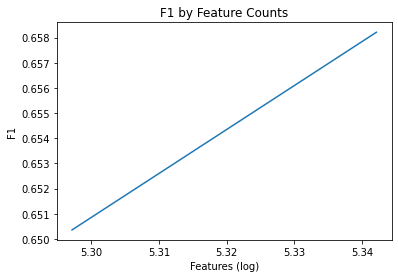

In [ ]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    import math

    ### STUDENT START ###

    #vectorize & transform text - bigrams
    vectorizer = CountVectorizer()
    vtrain = vectorizer.fit_transform(train_data)
    vdev = vectorizer.transform(dev_data)

    point_dict = {}
    cs = [0.1, 0.5, 1, 10, 100, 1000]

    for c in cs:

      print('C=', c)
      print(' ')

      clf_l1 = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty="l1")
      clf_l1.fit(vtrain, train_labels)
      preds_l1 = clf_l1.predict(vdev)
      print('F1, L1', metrics.f1_score(dev_labels, preds_l1, average="weighted"))

      #feature importances
      importance = clf_l1.coef_
      importances_list = []
      for x in importance:
        #only keep indexes that are not zero
        res = [idx for idx, val in enumerate(x) if val != 0]
        importances_list.append(res)
      importances_list = [item for sublist in importances_list for item in sublist]
      importances_list = list(set(importances_list))
      
      #remove all features not in that index list
      vect_names = vectorizer.get_feature_names()
      feature_names = [vect_names[i] for i in importances_list]

      def remove_features(text, feature_names):
        word_tokens = nltk.tokenize.word_tokenize(text)
        #remove zero features
        new_text = [w for w in word_tokens if w.lower() in feature_names]
        return new_text

      train_data_preprocessed = [' '.join(remove_features(i, feature_names)) for i in train_data]
      dev_data_preprocessed = [' '.join(remove_features(i, feature_names)) for i in dev_data]
      vectorizer = CountVectorizer()
      vtrain = vectorizer.fit_transform(train_data_preprocessed)
      vdev = vectorizer.transform(dev_data_preprocessed)

      #L2 classification
      clf_l2 = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty="l2")
      clf_l2.fit(vtrain, train_labels)
      preds_l2 = clf_l2.predict(vdev)
      print('Feature count:', len(feature_names))
      print('F1, L2', metrics.f1_score(dev_labels, preds_l2, average="weighted"))
      print('')

      def ln(x):
        n = 1000.0
        return n * ((x ** (1/n)) - 1)

      log_len = ln(len(feature_names))

      point_dict[log_len] = metrics.f1_score(dev_labels, preds_l2, average="weighted")

    lists = sorted(point_dict.items())

    x, y = zip(*lists)

    plt.plot(x,y)
    plt.title('F1 by Feature Counts')
    plt.xlabel('Features (log)')
    plt.ylabel('F1')
    plt.show()

    #relaxed gradient descent
    #clf_gd = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty="l1", tol=0.015)
    #clf_gd.fit(vtrain, train_labels)
    #preds_gd = clf_gd.predict(vdev)
    #print('F1, gradient descent', metrics.f1_score(dev_labels, preds_gd, average="weighted"))
    #print(' ')


    ### STUDENT END ###

Q6()

ANSWER: It appears that a lower number of features do correspond with higher model performance to a certain degree. However, in this particular instance th difference is not particularly material.

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [ ]:
def Q7():
    ### STUDENT START ###

      #vectorize & transform text
      vectorizer = TfidfVectorizer()
      vtrain = vectorizer.fit_transform(train_data)
      vdev = vectorizer.transform(dev_data)

      clf = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
      clf.fit(vtrain, train_labels)
      preds = clf.predict(vdev)
      print('F1', metrics.f1_score(dev_labels, preds, average="weighted"))
      probas = clf.predict_proba(vdev)
      probas_list = probas.tolist()
      dev_labels_list = dev_labels.tolist()

      max_dict = {}

      for i in range(len(probas_list)):
        if probas_list[i].index(max(probas_list[i])) != dev_labels[i]:
          r_ratio = max(probas_list[i]) / probas_list[i][dev_labels[i]]
          max_dict[i] = r_ratio

      my_keys = sorted(max_dict, key=max_dict.get, reverse=True)[:3]
      for k in list(my_keys):
        print(dev_data[k])
        print('')
      
    ### STUDENT END ###

Q7()

F1 0.7597662427853104
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this book. See the permissions notice in the book itself
for the pr

ANSWER: 1) CountVectorizer simply counts the frequency that a feature appears in a document. TFIDF stands for term frequency - inverse document frequency. This penalizes more common words (for example, stopwords) and very rare words in the corpus. Thus, the higher scored features indicate more significance. 
3) The R ratio demonstrates how wrong the model was with the incorrect guesses. 
4) The model is making mistakes distinguishing between the athiest category and the religion category. I would try to give more training data distinguishing between athiest text and religious text.

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.